# 4.2 Prediction Models

## Preparations

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import statsmodels as sm
import pandas as pd
import numpy as np
import xgboost as xgb
import datetime
import random
import pickle
import openpyxl
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import shap
import statistics

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = ''
df_top20 = pd.read_csv(path+'Data/df_top20.csv')
df_complex_complete = pd.DataFrame()

for i in df_top20.groupby('PULocationID'):
    A = i[1]

    df_complex = pd.concat([A['datetime'], A['PULocationID'], 
                            A['PULocationID'].astype(str)+'-'+A['pickup_day_of_week'].astype(str), 
                            np.cos((A['pickup_hour']*2*np.pi)/24), 
                            np.sin((A['pickup_hour']*2*np.pi)/24), np.cos((A['pickup_hour']*2*np.pi)/12),  
                            np.sin((A['pickup_hour']*2*np.pi)/12), A['count'], 
                            A['count'].shift(1), A['count'].shift(2),A['count'].shift(3), A['count'].shift(4),
                            A['count'].shift(5), A['count'].shift(6), A['count'].shift(7), A['count'].shift(8), 
                            A['count'].shift(9), A['count'].shift(10),A['count'].shift(11), A['count'].shift(12), 
                            A['count'].shift(13), A['count'].shift(14), A['count'].shift(15), A['count'].shift(16), 
                            A['count'].shift(17), A['count'].shift(18), A['count'].shift(19), A['count'].shift(20), 
                            A['count'].shift(21), A['count'].shift(22),   A['count'].shift(23), A['count'].shift(24), 
                            A['count'].shift(168), A['count'].shift(336), A['count'].shift(504), A['count'].shift(672)], 
                           axis = 1)

    df_complex.columns = ['datetime', 'PULocationID', 'categorical', 'cos_hour', 'sin_hour', 'cos_month', 
                          'sin_month', 'y', 'y-1', 'y-2', 'y-3', 'y-4','y-5', 'y-6', 'y-7', 'y-8', 'y-9', 
                          'y-10', 'y-11', 'y-12','y-13', 'y-14', 'y-15', 'y-16','y-17', 'y-18', 'y-19', 'y-20',
                      'y-21', 'y-22', 'y-23', 'y-24', 'y-1w', 'y-2w', 'y-3w', 'y-4w']
    df_complex_complete = df_complex_complete.append(df_complex, ignore_index = True) 

df_final = df_complex_complete.join(pd.get_dummies(df_complex_complete['categorical'])).dropna()
df_final.sort_values(['PULocationID', 'datetime'], inplace = True)

df_train = df_final.loc[(pd.to_datetime(df_final['datetime']) < pd.to_datetime('2011-01-01 00:00:00'))]
X_train = df_train.drop(['datetime', 'categorical','y'], axis = 1)
y_train = df_train['y']

In [3]:
# Metrics
def smape(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return 1/len(actual) * np.sum(2 * np.abs(forecast-actual) / (np.abs(actual) + np.abs(forecast))*100)

def rmse(actual, forecast):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return(np.sqrt(mean_squared_error(actual,forecast)))

In [4]:
# MAB Procedure
class MAB(object):
    """Base selector
    
    Args:
        models (dict): a dictionary of models from which the selector must choose at every
            call to ``select``.
        learning_strategy (func): a funct that represents the learning strategy utilized
            by the selector at every call to ``select``.
    """
    def __init__(self, models, learning_strategy):
        self.models = models
        self.ls = learning_strategy
        self.scores = dict.fromkeys(models.keys(), [1])
        self.history_model = []
        self.history_score = []
        self.history_pred = []
        self.history_y = []
        
        # change for zone specifity
        self.zone = [9999]

    def select(self, **kwargs):
        return max(self.scores, 
                   key=lambda i: self.ls([i, self.scores[i], self.history_model, self.history_score], **kwargs))
        
    def procedure(self, series, **kwargs):
        self.zone.append(series.loc['PULocationID'])
        X = series.iloc[~series.index.isin(['y', 'datetime', 'PULocationID', 'categorical'])]
        y = series['y']
        
        if self.zone[-1] != self.zone[-2]:
            self.scores = dict.fromkeys(models.keys(), [1])
        
        random_number = random.random()
        model = self.select(random_number = random_number, **kwargs)
        pred = max(0, self.models[model](X))
        percentage_error = np.abs(y-pred)/y
        percentage_accur = 1 - percentage_error
        self.scores[model] = self.scores[model] + [percentage_accur]
        
        self.history_model.append(model)
        self.history_pred.append(pred)
        self.history_score.append(percentage_accur)
        self.history_y.append(y)
        
    def execute(self, df, **kwargs):
        df.apply(self.procedure, **kwargs, axis = 1)

In [5]:
# learning strategies
def ls_xgboost(list, random_number):
    if list[0] == 'xgb':
        return 1
    else:
        return 0
    
def ls_naive(list, random_number):
    if list[0] == 'naive':
        return 1
    else:
        return 0

In [6]:
R = np.linspace(0, .5234375)
G = np.linspace(0, .734375)
B = np.linspace(0, .14453125)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
    red_list.append((x[i], R[i], R[i]))
    green_list.append((x[i], G[i], G[i]))
    blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict = LinearSegmentedColormap('cdict', cdict)

R = np.linspace(.5234375, 0)
G = np.linspace(.734375, 0)
B = np.linspace(.14453125, 0)
x = np.linspace(0, 1)

red_list = []
green_list = []
blue_list = []
for i in range(len(R)):
    red_list.append((x[i], R[i], R[i]))
    green_list.append((x[i], G[i], G[i]))
    blue_list.append((x[i], B[i], B[i]))

red_tuple = tuple(red_list)
green_tuple = tuple(green_list)
blue_tuple = tuple(blue_list)

cdict_r = {'red': red_tuple, 'green': green_tuple, 'blue':blue_tuple}
cdict_r = LinearSegmentedColormap('cdict_r', cdict_r)

## 4.2.1 Parameter Tuning

In [ ]:
# Bayesian Optimization
from skopt import forest_minimize
from sklearn.model_selection import cross_val_score

def tune_xgbc(params):
# Implementation learned on a lesson of Mario Filho (Kagle Grandmaster) for parametes optmization.
# Link to the video: https://www.youtube.com/watch?v=WhnkeasZNHI

    """Function to be passed as scikit-optimize minimizer/maximizer input

    Parameters:
    Tuples with information about the range that the optimizer should use for that parameter, 
    as well as the behaviour that it should follow in that range.

    Returns:
    float: the metric that should be minimized. If the objective is maximization, then the negative 
    of the desired metric must be returned. In this case, the negative AUC average generated by CV is returned.
    """


    #Hyperparameters to be optimized
    print(params)
    learning_rate = params[0] 
    n_estimators = params[1] 
    max_depth = params[2]
    min_child_weight = params[3]
    gamma = params[4]
    subsample = params[5]
    colsample_bytree = params[6]


    #Model to be optimized
    mdl = xgb.XGBRegressor(learning_rate = learning_rate, 
                            n_estimators = n_estimators, 
                            max_depth = max_depth, 
                            min_child_weight = min_child_weight, 
                            gamma = gamma, 
                            subsample = subsample, 
                            colsample_bytree = colsample_bytree, seed = 42)


    #Cross-Validation in order to avoid overfitting
    nmse = cross_val_score(mdl, X_train, y_train, cv = 2, scoring = 'neg_mean_squared_error')

    print(nmse.mean())
    # as the function is minimization (forest_minimize), we need to use the negative of the desired metric (AUC)
    return -nmse.mean()

# Creating a sample space in which the initial randomic search should be performed
space = [(1e-3, 1e-1, 'log-uniform'), # learning rate
          (10, 100), # n_estimators
          (1, 10), # max_depth 
          (1, 6.), # min_child_weight 
          (0, 0.5), # gamma 
          (0.5, 1.), # subsample 
          (0.5, 1.)] # colsample_bytree 

# Minimization using a random forest with 20 random samples and 50 iterations for Bayesian optimization.
result = forest_minimize(tune_xgbc, space, random_state = 42, n_initial_points = 0, n_calls  = 20, verbose = 1, 
                         x0=old_result.x_iters, y0=old_result.func_vals)

dump(result, 'results.pkl')

In [ ]:
result.x

### Model configurations

In [7]:
# XGBoost
params = [0.06759574377750831,82,8,3.247253370691017, 0.04770505824520567,0.6854091260991332, 0.8344206263318037]

In [8]:
# prediction models
def naive(X):
    return X['y-1']

def xgboost(X):
    return xgb_model.predict(X.values.reshape(1,172), validate_features = False)[0]

### XGBoost

In [ ]:
# Model Training
years = range(2011, 2021)

for j in years:    

    df_train_j = df_final[(df_final['datetime']>str(j-3)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-01-01 00:00:00')]
    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    X_train_j = df_train_j.drop(['datetime', 'categorical','y'], axis = 1)
    y_train_j = df_train_j['y']
    
    print('year:',j, '|',datetime.datetime.now().time())
    xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',
                                 learning_rate = params[0], 
                                 n_estimators = params[1], 
                                 max_depth = params[2], 
                                 min_child_weight = params[3], 
                                 gamma = params[4], 
                                 subsample = params[5], 
                                 colsample_bytree = params[6], 
                                 seed = 42)
    
    print('Training...',datetime.datetime.now().time())
    xgb_model.fit(X_train_j, y_train_j)
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    pickle.dump(xgb_model, open(name, "wb"))

In [ ]:
years = range(2011, 2021)
results = []

for j in years:
    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))    
    
    print(j, '| Predicting |',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ls_xgboost)
    selector.execute(df_test_j)
    results.append(selector)
    print(j,'| Finished |',datetime.datetime.now().time())       

In [ ]:
pickle.dump(results, open(path+"Results/xgb_only.dat", "wb"))

### Naive Model

In [ ]:
years = range(2011, 2021)
results = []

for j in years:
    df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))    
    
    print(j, '| Predicting |',datetime.datetime.now().time())
    models = {'naive':naive, 'xgb':xgboost}
    selector = MAB(models, ls_naive)
    selector.execute(df_test_j)
    results.append(selector)
    print(j,'| Finished |',datetime.datetime.now().time())       

In [ ]:
pickle.dump(results, open(path+"Results/naive_only.dat", "wb"))

### Benchmark with Baier et al.

In [ ]:
baier_pred_naive = []
baier_y = []

for j in range(2011, 2019):
    if j == 2018:
        df_train_j = df_final[(df_final['datetime']>str(j-3)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-01-01 00:00:00')]
        df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-07-01 00:00:00')]
    
        
    else:
        df_train_j = df_final[(df_final['datetime']>str(j-3)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-01-01 00:00:00')]
        df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    X_train_j = df_train_j.drop(['datetime', 'categorical','y'], axis = 1)
    y_train_j = df_train_j['y']
    
    X_test_j = df_test_j.drop(['datetime', 'categorical','y'], axis = 1)
    y_test_j = df_test_j['y']
    baier_y.extend(y_test_j.tolist()) 
    
    print(j)
    y_pred = X_test_j['y-1']
    baier_pred_naive.extend(y_pred.tolist())
    print(datetime.datetime.now().time())

In [ ]:
baier_pred_xgb = []
baier_y = []

for j in range(2011, 2019):
    if j == 2018:
        df_train_j = df_final[(df_final['datetime']>str(j-3)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-01-01 00:00:00')]
        df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-07-01 00:00:00')]
    
        
    else:
        df_train_j = df_final[(df_final['datetime']>str(j-3)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-01-01 00:00:00')]
        df_test_j = df_final[(df_final['datetime']>str(j-1)+'-12-31 23:00:00')&(df_final['datetime']<str(j+1)+'-01-01 00:00:00')]
    
    X_train_j = df_train_j.drop(['datetime', 'categorical','y'], axis = 1)
    y_train_j = df_train_j['y']
    
    X_test_j = df_test_j.drop(['datetime', 'categorical','y'], axis = 1)
    y_test_j = df_test_j['y']
    baier_y.extend(y_test_j.tolist()) 
    
    print(j)
    xgb_model = xgb.XGBRegressor(learning_rate = params[0], 
                            n_estimators = params[1], 
                            max_depth = params[2], 
                            min_child_weight = params[3], 
                            gamma = params[4], 
                            subsample = params[5], 
                            colsample_bytree = params[6], seed = 42)
    xgb_model.fit(X_train_j, y_train_j)
    y_pred = xgb_model.predict(X_test_j)
    baier_pred_xgb.extend(y_pred.tolist())
    
    print(datetime.datetime.now().time())

In [ ]:
baier_naive_rmse = rmse(np.array(baier_y), np.array(baier_pred_naive))
baier_naive_smape = smape(np.array(baier_y), np.array(baier_pred_naive))

In [ ]:
baier_xgb_rmse = rmse(baier_y, baier_pred_xgb)
baier_xgb_smape = smape(np.array(baier_y), np.array(baier_pred_xgb))

In [ ]:
pd.DataFrame(data = {'smape':[baier_naive_smape, baier_xgb_smape], 'rmse':[baier_naive_rmse, baier_xgb_rmse]})

## 4.2.2 Feature Importance

In [ ]:
row = 0
column = 0

for j in range(2011, 2021):
    train_years = str(j-2)[-2:]+str(j-1)[-2:]
    X_test = df_final[(df_final['datetime']>str(j-3)+'-12-31 23:00:00')&(df_final['datetime']<str(j)+'-01-01 00:00:00')]
    X = X_test.iloc[:, ~X_test.columns.isin(['y', 'datetime', 'PULocationID', 'categorical'])]
    name = path+"Models/train_"+train_years+".dat"
    xgb_model = pickle.load(open(name, "rb"))
    
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X, )
    shap.summary_plot(shap_values, X, max_display= 10, cmap = 'summer')


    column = column + 1
    if column == 2:
        row = row + 1
        column = 0

## 4.2.3 Predictive Performance

In [9]:
xgb_only = pickle.load(open(path+"Results/xgb_only.dat", "rb"))
naive_only = pickle.load(open(path+"Results/naive_only.dat", "rb"))

In [11]:
df_test = df_final[(df_final['datetime']>'2010-12-31 23:00:00')]
df_test = df_test[['datetime', 'PULocationID', 'categorical', 'y']]
df_test['datetime'] = pd.to_datetime(df_test['datetime'])
df_test['year'] = pd.to_numeric(df_test['datetime'].dt.strftime('%Y'))
df_test['doy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%j'))
df_test['woy'] = pd.to_numeric(df_test['datetime'].dt.strftime('%W'))

xgb_preds = []
naive_preds = []

for i in range(len(xgb_only)):
    xgb_year_preds = xgb_only[i].history_pred
    naive_year_preds = naive_only[i].history_pred
    xgb_preds.append(xgb_year_preds)
    naive_preds.append(naive_year_preds)

df_test.sort_values(['year', 'PULocationID', 'datetime'], inplace = True)
df_test['xgb'] = [item for elem in xgb_preds for item in elem]
df_test['naive'] = [item for elem in naive_preds for item in elem]

In [12]:
yearly_xgb_smape = []
yearly_xgb_rmse = []
yearly_naive_smape = []
yearly_naive_rmse = []
yearly_titles = []
for title, group in df_test.groupby(['year']):
    yearly_titles.append(title)
    yearly_xgb_smape.append(smape(group['xgb'], group['y']))
    yearly_xgb_rmse.append(rmse(group['xgb'], group['y']))
    yearly_naive_smape.append(smape(group['naive'], group['y']))
    yearly_naive_rmse.append(rmse(group['naive'], group['y']))

yearly = pd.DataFrame({'date': yearly_titles, 
                       'xgb_smape':yearly_xgb_smape, 
                       'naive_smape':yearly_naive_smape, 
                       'xgb_rmse':yearly_xgb_rmse, 
                       'naive_rmse':yearly_naive_rmse})

In [13]:
print(yearly.to_latex( float_format="%.2f", index = False))

\begin{tabular}{rrrrr}
\toprule
 date &  xgb\_smape &  naive\_smape &  xgb\_rmse &  naive\_rmse \\
\midrule
 2011 &      10.81 &        26.20 &     70.78 &      150.49 \\
 2012 &       9.77 &        26.41 &     67.84 &      153.18 \\
 2013 &      10.00 &        26.61 &     68.12 &      151.45 \\
 2014 &      10.03 &        26.18 &     65.43 &      142.40 \\
 2015 &      10.55 &        26.12 &     61.23 &      126.60 \\
 2016 &      11.27 &        26.19 &     57.80 &      115.55 \\
 2017 &      11.61 &        26.60 &     52.00 &      102.05 \\
 2018 &      11.89 &        27.43 &     47.74 &       94.17 \\
 2019 &      13.01 &        28.55 &     42.19 &       79.91 \\
 2020 &      51.26 &        39.01 &     28.71 &       39.17 \\
\bottomrule
\end{tabular}



In [14]:
print(smape(df_test['y'], df_test['xgb']), smape(df_test['y'], df_test['naive']))
print(rmse(df_test['y'], df_test['xgb']), rmse(df_test['y'], df_test['naive']))

14.861623287025488 27.882354085027615
57.72512845788117 121.03608074203618


In [15]:
weekly_xgb_smape = []
weekly_xgb_rmse = []
weekly_naive_smape = []
weekly_naive_rmse = []
weekly_titles = []
for title, group in df_test.groupby(['year', 'woy']):
    weekly_titles.append(str(title[1])+'-'+str(title[0]))
    weekly_xgb_smape.append(smape(group['xgb'], group['y']))
    weekly_xgb_rmse.append(rmse(group['xgb'], group['y']))
    weekly_naive_smape.append(smape(group['naive'], group['y']))
    weekly_naive_rmse.append(rmse(group['naive'], group['y']))

weekly = pd.DataFrame({'date': weekly_titles, 
                       'xgb_smape':weekly_xgb_smape, 
                       'naive_smape':weekly_naive_smape, 
                       'xgb_rmse':weekly_xgb_rmse, 
                       'naive_rmse':weekly_naive_rmse})

<AxesSubplot:title={'center':'RMSE'}, xlabel='date'>

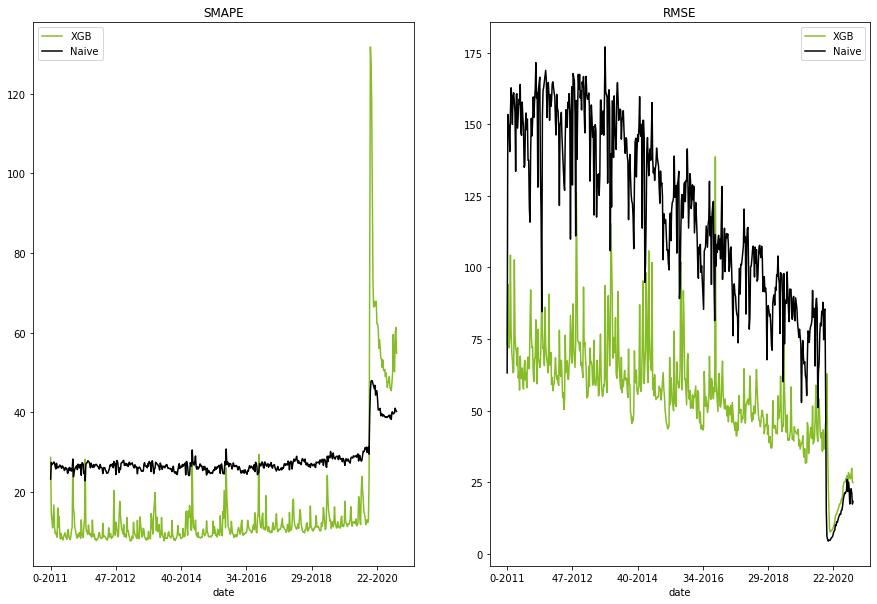

In [16]:
# Weekly sMAPE and RMSE of XGBoost and naive model
fig, axes = plt.subplots(ncols = 2, figsize = (15, 10))
weekly.plot(x = 'date', y = ['xgb_smape', 'naive_smape'], ax = axes[0], 
            color = ['#86BC25', '#000000'], label = ['XGB', 'Naive'], title = 'SMAPE')
weekly.plot(x = 'date', y = ['xgb_rmse', 'naive_rmse'], ax = axes[1], 
            color = ['#86BC25', '#000000'], label = ['XGB', 'Naive'], title = 'RMSE')